In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [3]:
features = ['fico', 'int.rate', 'dti', 'revol.util', 'inq.last.6mths', 'credit.policy']
target = 'not.fully.paid'

def create_synthetic_data(n_samples=10000):
    data = {
        'fico': np.random.normal(700, 50, n_samples).clip(300, 850),
        'int.rate': np.random.uniform(0.05, 0.25, n_samples),
        'dti': np.random.normal(20, 10, n_samples).clip(0, 50),
        'revol.util': np.random.uniform(0, 100, n_samples),
        'inq.last.6mths': np.random.poisson(1, n_samples).clip(0, 10),
        'credit.policy': np.random.binomial(1, 0.8, n_samples),
        'not.fully.paid': np.random.binomial(1, 0.15, n_samples)  # ~15% defaults
    }
    return pd.DataFrame(data)

df = create_synthetic_data()

In [4]:
# Preprocess data
# Handle missing values
imputer = SimpleImputer(strategy='median')
df[features] = imputer.fit_transform(df[features])

# Split features and target
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)
print("Random Forest model trained.")

Random Forest model trained.


In [6]:
# Evaluate model
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Model Performance:")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Performance:
AUC-ROC: 0.4833
Precision: 0.0000
Recall: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1700
           1       0.00      0.00      0.00       300

    accuracy                           0.85      2000
   macro avg       0.42      0.50      0.46      2000
weighted avg       0.72      0.85      0.78      2000



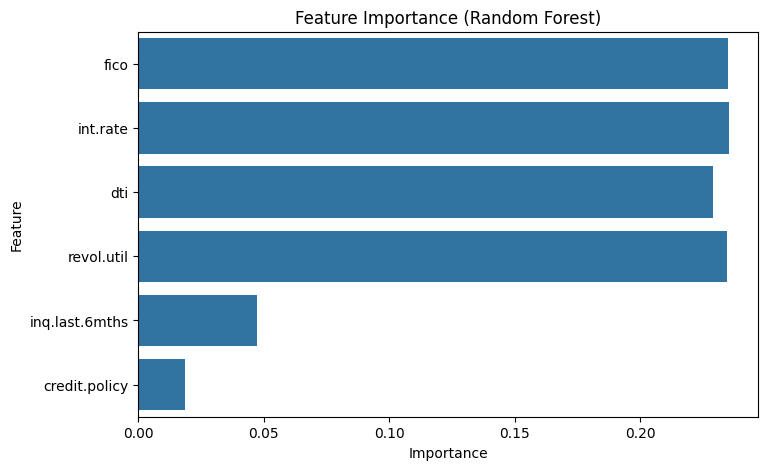

In [7]:
# Plot feature importance
plt.figure(figsize=(8, 5))
feature_importance = pd.Series(model.feature_importances_, index=features)
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.show()

In [8]:
# Save model, scaler, and imputer
joblib.dump(model, 'loan_approval_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(imputer, 'imputer.pkl')
print("Model, scaler, and imputer saved.")

Model, scaler, and imputer saved.


In [9]:
# Function for new predictions
def predict_new_data(new_data, model, scaler, imputer):
    new_data = new_data[features]
    new_data = imputer.transform(new_data)
    new_data_scaled = scaler.transform(new_data)
    predictions = model.predict(new_data_scaled)
    probabilities = model.predict_proba(new_data_scaled)[:, 1]
    return predictions, probabilities

# Example prediction
new_sample = pd.DataFrame({
    'fico': [650],
    'int.rate': [0.12],
    'dti': [25],
    'revol.util': [60],
    'inq.last.6mths': [2],
    'credit.policy': [1]
})
pred, prob = predict_new_data(new_sample, model, scaler, imputer)
print(f"New Sample Prediction: {'Default' if pred[0] == 1 else 'No Default'} (Probability: {prob[0]:.2f})")

New Sample Prediction: No Default (Probability: 0.17)


d:\Aitomated Loan Approval\venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
